## Explain the black-box: post-hoc methods for tabular data
### Author: Francesca Naretto
### Dataset: Adult dataset ( arleady cleaned)

In [ ]:
!git clone https://github.com/francescanaretto/XAI-course_2021

In [44]:
! pip install shap

In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

In [6]:
#we load the adult dataset
#this is a clean version, in which the education feature is removed
#categorical variables are mapped in numerical ones
dataset = pd.read_csv('/content/XAI-course_2021/Tabular/datasets/adult_clean.csv')

In [7]:
dataset.head()

age  workclass  fnlwgt  ...  hours-per-week  native-country  class
0   39          0   77516  ...              40              41      0
1   50          1   83311  ...              13              41      0
2   38          2  215646  ...              40              41      0
3   53          2  234721  ...              40              41      0
4   28          2  338409  ...              40               1      0

[5 rows x 14 columns]

### We split the dataset into train and test for training the black-box

In [8]:
test_size = 0.3
random_state = 42
labels = dataset.pop('class')
features = list(dataset.columns)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=labels)

### We train the black-box: a Random Forest classifier. To achieve good performance, we conduct a small grid search for the best setting of the hyper-parameters.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(X_test, Y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 16, 22, 29, 35, 42,
                                                      48, 55, 61, 67, 74, 80,
                                                      87, 93, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150]},
                   random_state=42, verbose=2)

In [11]:
#this is the best configuration for this setting 
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 67,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 140}

### Train the Random Forest and check the performance for both train and test

In [12]:
bb = RandomForestClassifier(n_estimators=140, min_samples_split= 5, min_samples_leaf=4, max_features='sqrt', max_depth=67, bootstrap=True,  random_state=random_state)
bb.fit(X_train.values, Y_train.values)

RandomForestClassifier(max_depth=67, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=140, random_state=42)

In [13]:
Y_pred = bb.predict(X_train)
print(classification_report(Y_train, Y_pred))

X has feature names, but RandomForestClassifier was fitted without feature names


              precision    recall  f1-score   support

           0       0.91      0.97      0.94     15857
           1       0.88      0.72      0.79      5256

    accuracy                           0.91     21113
   macro avg       0.90      0.84      0.87     21113
weighted avg       0.90      0.91      0.90     21113



In [14]:
Y_pred = bb.predict(X_test)
print(classification_report(Y_test, Y_pred))

X has feature names, but RandomForestClassifier was fitted without feature names


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6797
           1       0.78      0.62      0.69      2252

    accuracy                           0.86      9049
   macro avg       0.83      0.78      0.80      9049
weighted avg       0.86      0.86      0.86      9049



## Explain the results
### Here we focus on post-hoc methods. We can have local or global explanations: in the first case, the goal is to understand the reasons that lead the black-box to classify that record in that way, while in the second case the goal is to understand at a higher level the reasoning of the black-box model.

### We first try to explain our black-box model with ***SHAP***. This method allows for different kinds of explainers:
1. Kernel Explainer, it is the ***real*** agnostic method for computing Shap values. Hence, it works for every kind of ML model (quite slow). 
2. Linear Explainer, for explaining linear models. It is an exact method. It allows for an analysis with independent variables, as well as for correlated ones (you have to estimates the variables covariance matrix).
3. Tree Explainer, for explaining tree-based models (tree and ensambles). Is is an exact algorithm. 
4. Gradient Explainer, for explaining deep learning models. It is based on Integrated Gradient and it is an approximation algorithm.  
5. Deep Explainer, for explaining deep learning models. It is based on DEEPLift and the method computes an approximation algorithm (faster than Gradient Explainer).

In [57]:
shap_values_tree = shap.TreeExplainer(bb).shap_values(X_test[0:200])

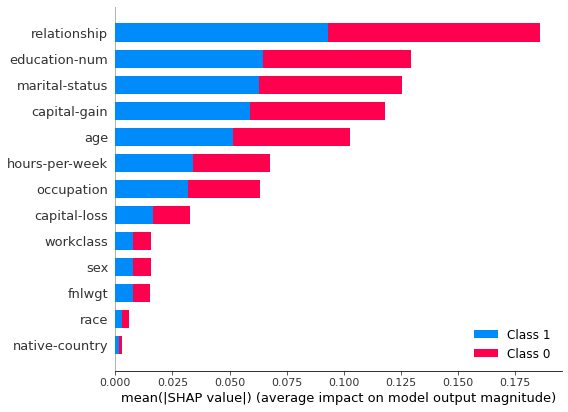

In [58]:
shap.summary_plot(shap_values_tree, X_test[0:200])

In [59]:
shap_values_tree[0].shape

(200, 13)

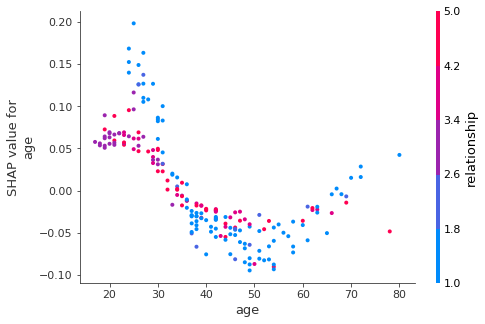

In [60]:
shap.dependence_plot("age", shap_values_tree[0], X_test[0:200])

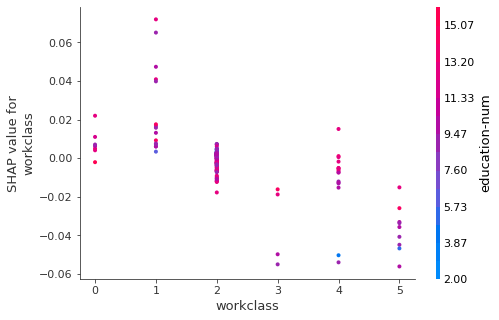

In [61]:
shap.dependence_plot("workclass", shap_values_tree[0], X_test[0:200])

In [62]:
shap_interaction_values_tree = shap.TreeExplainer(bb).shap_interaction_values(X_test.iloc[0:20])

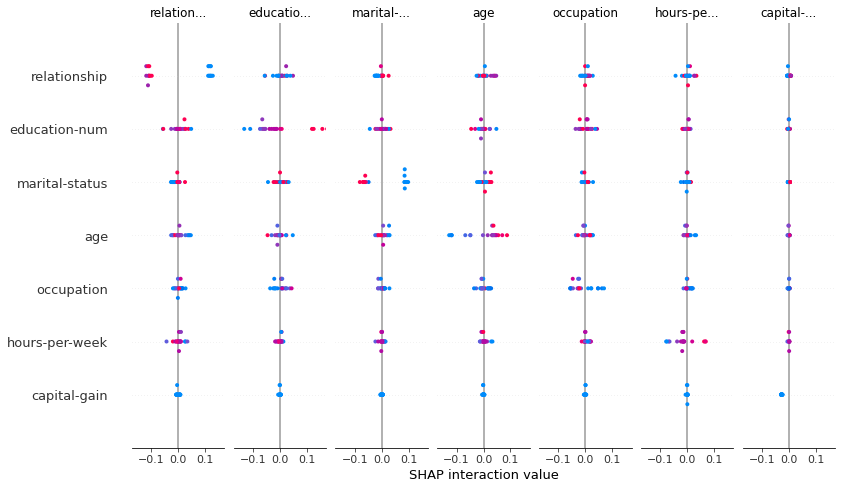

In [63]:
shap.summary_plot(shap_interaction_values_tree[1], X_test.iloc[0:20])

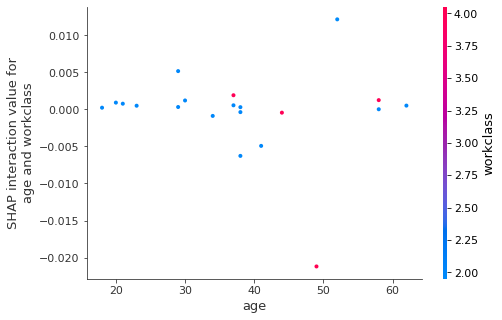

In [64]:
shap.dependence_plot(
    ("age", "workclass"),
    shap_interaction_values_tree[0], X_test.iloc[0:20]
)

In [65]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(bb).expected_value[0], shap_values_tree[0], X_test[0:200])

### Local explanation 

In [32]:
X_test.iloc[0]

age                   29
workclass              2
fnlwgt            169683
education-num         11
marital-status         1
occupation             3
relationship           1
race                   1
sex                    0
capital-gain           0
capital-loss           0
hours-per-week        40
native-country        41
Name: 21746, dtype: int64

In [35]:
bb.predict(X_test.values[0].reshape(1, -1))

array([0])

In [66]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(bb).expected_value[0], shap_values_tree[0][0,:], features)

In [42]:
bb.predict(X_test.values[2].reshape(1, -1))

array([1])

In [67]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(bb).expected_value[1], shap_values_tree[1][2,:], features)

**Another example**


Let's try a different explainer: before we used the TreeExplainer, but there are other explainers available in SHAP. Since we are dealing with a RandomForest, another possibility could be the KernelExplainer, that is completley agnostic.

KernelExplainer requires in input the predict_proba of the black-box we want to explain and a sample of the data. In this simple example we use just the first 20 records of the test set, but in principle you can pass whatever representation of your data, such as the centroids obtained from a clustering algorithm.

In [68]:
shap_values_kernel = shap.KernelExplainer(bb.predict_proba, X_test[0:20]).shap_values(X_test[0:200])

  0%|          | 0/200 [00:00<?, ?it/s]

In [69]:
shap.initjs()
shap.force_plot(shap.KernelExplainer(bb.predict_proba, X_test[0:20]).expected_value[0], shap_values_kernel[0], X_test[0:200])

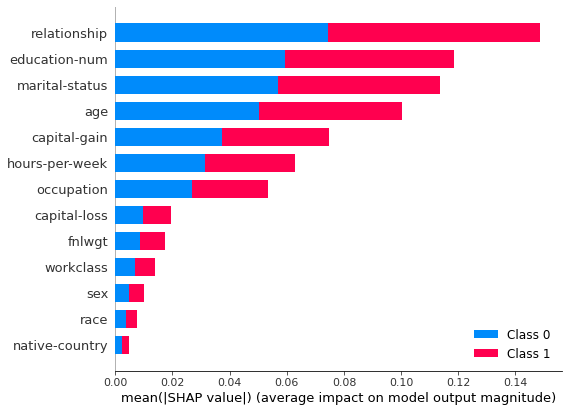

In [70]:
shap.summary_plot(shap_values_kernel, X_test[0:200])

In [73]:
shap.initjs()
shap.force_plot(shap.KernelExplainer(bb.predict_proba, X_test[0:20]).expected_value[1], shap_values_kernel[1][2,:], features)